# Case Study Unit 4 - Signal Frontier Analysis
### Cory Adams, Chris Boomhower, Alexandra Fisher, Alex Frye
### *MSDS 7333, September 26, 2017*

## Abstract
While the history of financial trade markets as we know them today spans centuries, the adoption of Python to study market trends has really only gained traction since 2005 [4,8]. The language has been used to study everything from historical stock price trends to rolling correlation and linear regression. This case study is performed to demonstrate Python's effectiveness for studying stock cumulative returns and to test the principles of short, intermediate, and long term momentum. The dataset analyzed consists of a mock-up portfolio of five semiconductor industry stocks. Prices were pulled over a ten year timeframe and cumulative returns explored. Momentums were calculated for various lookback and holding periods with the expectation that short and long term periods would exhibit inverted outcomes and intermediate term periods would exhibit a continued trend over future periods of similar length. Finally, research's theory for best strategy being a lookback period of one year with a holding period of three months is tested using this portfolio data [7]. Next steps, including use of the R statistical language to replicate this analysis, are finally discussed.

## Introduction
Financial stock market data can be rather challenging to analyze without adequate tools. Fortunately, libraries such as Python's *pandas* module make working with financial and time-series data very straightforward. The *pandas* library efficiently indexes time-sensitive data, supports operations for time-series of different frequencies, handles "as of" data imputation, and even provides functions conducive to stock value analysis with respect to time.

To evaluate *pandas* capabilities, we put the toolset to work on momentum analysis. Existing research indicates three types of momentum: 1) Short (1 month), 2) Intermediate (6-12 months), and 3) Long (3-5 years) [1,6,7]. This research reveals that both short and long term momentums exhibit reversal in short and long term future values. In contrast, intermediate term momentum demonstrates continued stock portfolio performance over intermediate future periods. Additionally, studies argue the best strategy is to use a lookback period of one year with a holding period of three months when determining when to buy or sell [7]. These are interesting principles and their analysis using real, historical stock values make for a great case study to evaluate Python and *pandas* for financial data applications. As such, a mock-up stock portofilio consisting of Texas Instruments (TXN), ON Semiconductor (ON), Nexperia (NXPI), Diodes (DIOD), and Maxim (MXIM) stocks will be reviewed and cumulative returns and momentum analyzed.

Our first task is to simply load all necessary modules as below.

In [1]:
## Load necessary modules
import pandas_datareader as web
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict
import datetime
from IPython.display import display
import missingno as msno

%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Methods
Multiple steps were formulated and followed in order to perform our analysis and to demonstrate Python's and *pandas'* capacity for portfolio assessment. These steps are outlined as follows:
1. Pull 10 years worth of semiconductor portfolio data, leaving enough buffer for at least 3 years lookback
2. Perform exploratory cumulative return analysis to better understand portfolio stock health
3. Analyze short term momentum
4. Analyze intermediate term momentum
5. Analyze long term momentum
6. Review results against theory that 12 month loopback with 3 month holding is best strategy


Note that our cumulative returns and momentum code are modifications of code examples found in *Python for Data Analysis*, Chapter 11, pages 345-347 [9].




## Results

### 1) Loading Stock Portfolio Data

To begin our analysis, the first step is to load data for our target stocks. Utilizing the *pandas_datareader* python package, we are able to capture adjusted close data from yahoo finance. In order to account for momentum calculations, including prior year statistics, we have decided to pull a full 10 years of historical business day prices for this analysis from 6-30-2007 to 6-30-2017 as may be seen in rendered head and tail outputs below. 

In [2]:
## If RemoteDataError received upon chunk run, rerun until data pulled successfully
names = ['TXN', 'ON', 'NXPI', 'DIOD', 'MXIM']
def get_px(stock, start, end):
    return web.DataReader(stock, 'yahoo', start, end)

s = datetime.datetime(2007, 6, 30)
e = datetime.datetime(2017, 6, 29) #Offset by one day

px = ''
tryCnt = 1
while(tryCnt >0):
    try:
        px = pd.DataFrame({n:get_px(n, s, e)['Adj Close'] for n in names})
        print("Successful Data Load on attempt {0}.".format(tryCnt))
        tryCnt = -1
    except:
        print("Error Occurred on attempt",tryCnt, "... Trying again.")
        tryCnt+=1
display(px.head())
display(px.tail())

Error Occurred on attempt 1 ... Trying again.
Successful Data Load on attempt 2.


,DIOD,MXIM,NXPI,ON,TXN
Date,,,,,
2007-07-02,27.440001,22.715092,NaN,11.10,30.190571
2007-07-03,28.193333,22.667503,NaN,11.27,30.301619
2007-07-05,27.906666,23.014238,NaN,11.35,30.238171
2007-07-06,28.026667,23.027836,NaN,11.40,30.412683
2007-07-09,28.506666,23.259001,NaN,11.32,30.341288


,DIOD,MXIM,NXPI,ON,TXN
Date,,,,,
2017-06-26,24.910000,45.414894,109.730003,14.97,77.835564
2017-06-27,23.889999,44.373272,109.519997,14.37,76.483803
2017-06-28,24.709999,44.690720,109.900002,14.65,77.587082
2017-06-29,24.420000,44.085583,109.400002,14.22,76.434113
2017-06-30,24.030001,44.541916,109.449997,14.04,76.463928


**Missing Data** Upon our initial loading of the data we see that there are missing values for NXPI. To gain high level exposure to missing values within this dataset, we have produced a missing value plot below. In this plot we identify the only stock for which we do not have the full 10 year date span is NXPI. This is expected, as can be confirmed through NASDAQ; NXPI entered the market on 8/6/2010 [5]. All data prior to this time for NXPI has resulted in NaN values. 

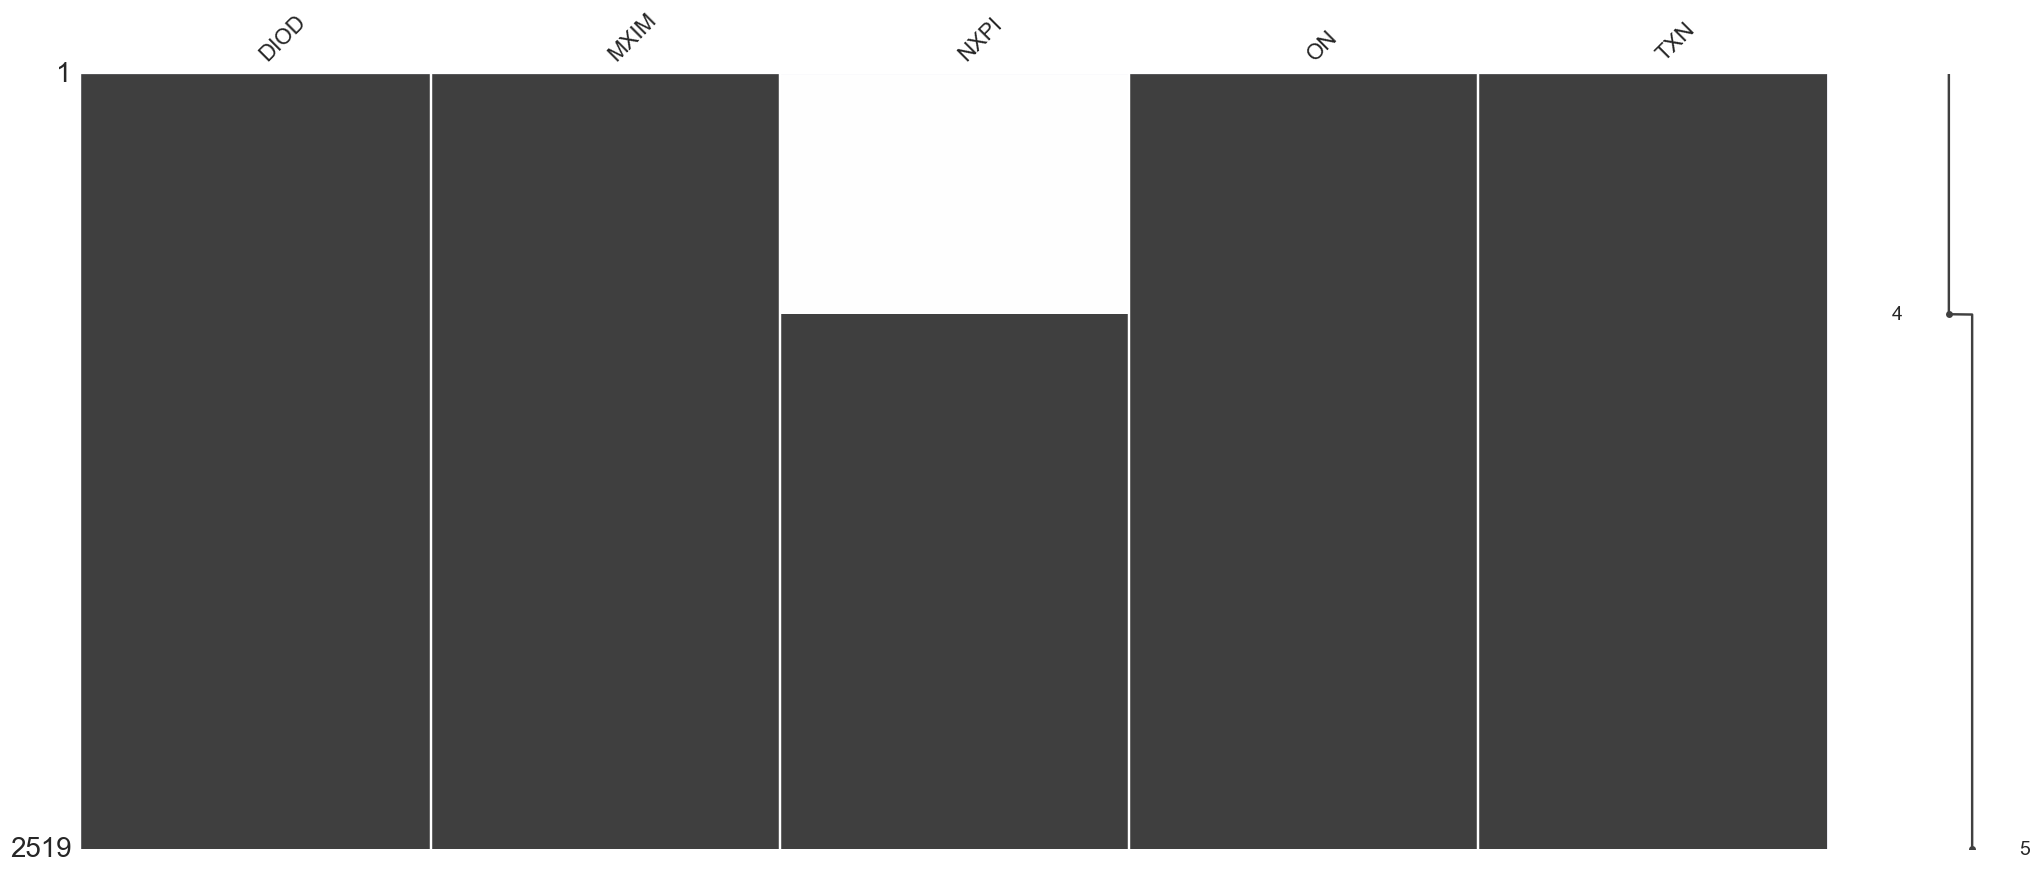

In [3]:
#Plot for missing Data
filtered_msnoData = msno.nullity_sort(msno.nullity_filter(px))
msno.matrix(filtered_msnoData)

del filtered_msnoData

Shown below, we confirm this data has loaded properly and that missing values stop after 2010-08-05. This matches our findings on NASDAQ, and we may proceed with confidence knowing the data has loaded successfully.

In [4]:
display(pd.DataFrame(pd.concat([pd.Series(px[px["NXPI"].isnull()].NXPI.tail()), pd.Series(px[px["NXPI"].notnull()].NXPI.head())])).T)

Date,2010-07-30 00:00:00,2010-08-02 00:00:00,2010-08-03 00:00:00,2010-08-04 00:00:00,2010-08-05 00:00:00,2010-08-06 00:00:00,2010-08-09 00:00:00,2010-08-10 00:00:00,2010-08-11 00:00:00,2010-08-12 00:00:00
NXPI,NaN,NaN,NaN,NaN,NaN,14.0,14.0,13.6,12.75,12.39


### 2) Exploratory Data Analysis - Stock Price and Cumulative Returns

To explore these stocks, prior to further analysis, we have plotted both stock prices and cumulative returns across the most recent 3 Month, 1 Year, 3 Year, and 10 Year Periods. These plots are divided into 3 rows: 1) Stock Prices, 2) Cumulative Returns with Standardized Scale, 3) Cumulative Returns with Zoomed Scale, and are shown below the next code chunk. To provide a better picture of the data, cumulative returns are displayed with two different y-scale ranges.

**Stock Prices** While we do not have the NXPI data element prior to August 2010, it is definitely apparent that NXPI has had a tremendously successful time in the market since inception. With prices ranging from approximately \$14 in 2010 all the way to approximately \$110 in 2017, it is followed next by TXN with an ending price of only approximately $80 in 2017. Although NXPI has had the most successful upward trend in the long term, it also appears the most volatile. We notice, especially in the 3 year range, that there are much larger peaks and valleys than in the other prices. This factor likely attributes NXPI as a higher risk stock option than others plotted at its side. 

**Cumulative Returns** The formula for cumulative returns is:<br><br>

<center> $\frac{(Current Price of Security - Original Price of Security)}{(Original Price of Security)}$     [2] </center>

This computation allows us to assess aggregate gain or loss from an initialized starting date. These plots display return percentages in decimal form. The second row of cumulative return plots provide us context toward aggregate gains in the short term versus long term, showing the powerful plunge of NXPI in the early years of inception. However, what was difficult to understand in the stock price visualizations is that NXPI does not actually take the win in the intermediate 1-3 year terms. As we dive into the scaled visuals of these same values, we find that DIOD, second to last in cumulative returns over the 10 year period, takes the win by nearly 20% in the 1 year period. This goes to show that buy and hold methodologies are very important to your overall investment strategy!

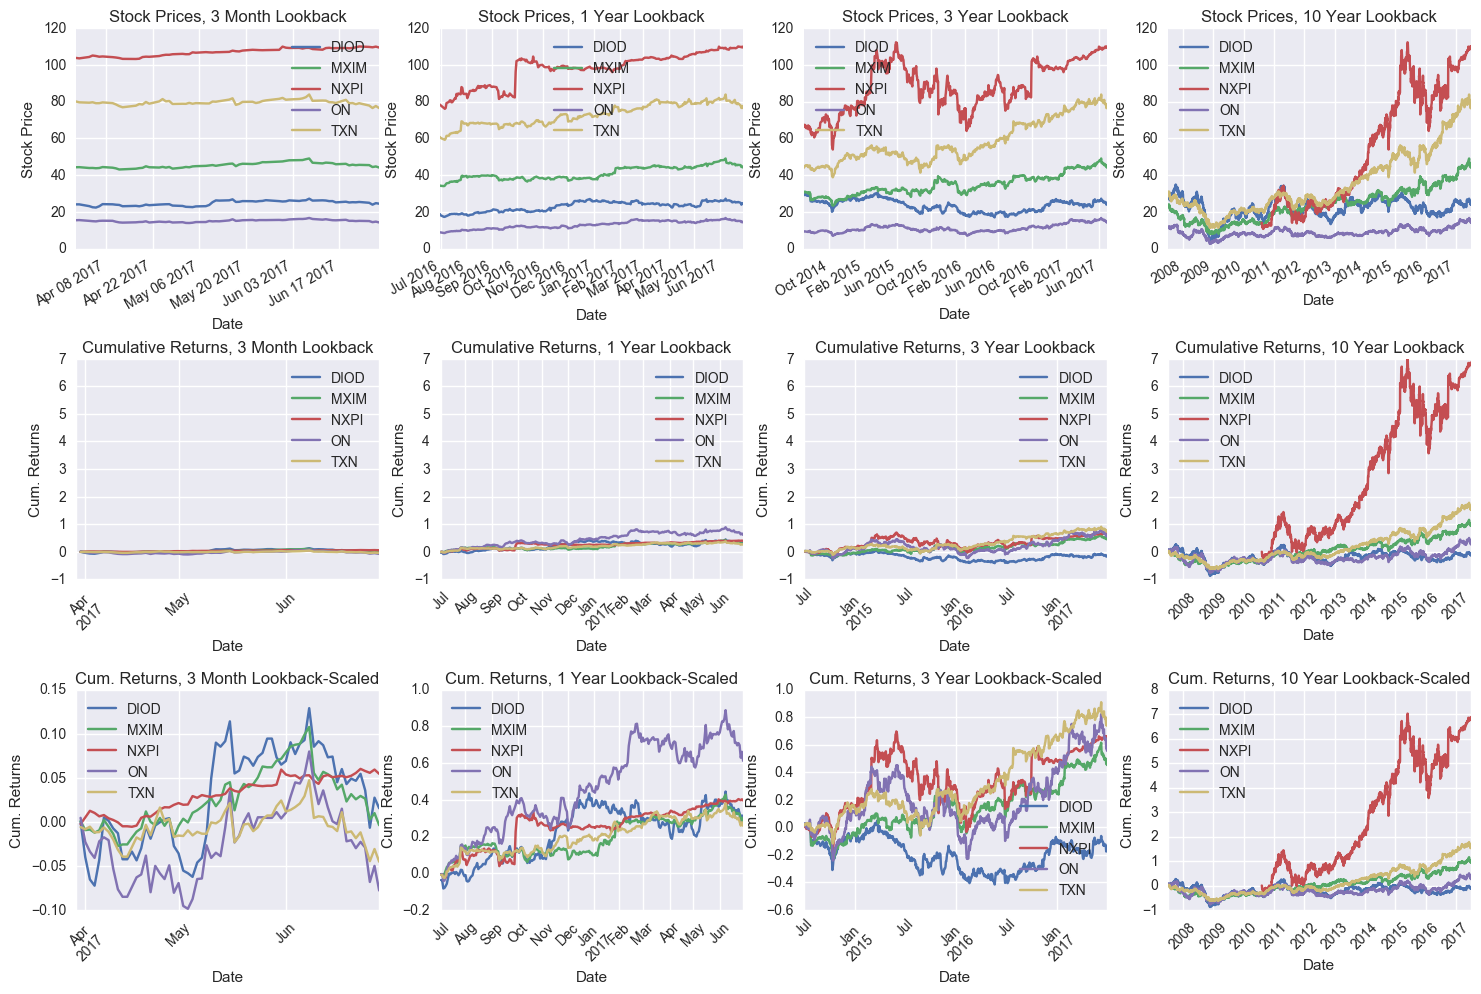

In [5]:
plt.rcParams['figure.figsize'] = (18, 9)
fig = plt.figure()

###### Stock Prices ######
# 3 month
ax = fig.add_subplot(3,4,1)
ax.set_ylabel("Stock Price")
px.ix['2017-03-30':'2017-06-29'].plot(ax=ax, title = "Stock Prices, 3 Month Lookback")

# 1 Year
ax = fig.add_subplot(3,4,2)
ax.set_ylabel("Stock Price")
px.ix['2016-06-30':'2017-06-29'].plot(ax=ax, title = "Stock Prices, 1 Year Lookback")

# 3 Year
ax = fig.add_subplot(3,4,3)
ax.set_ylabel("Stock Price")
px.ix['2014-06-30':'2017-06-29'].plot(ax=ax, title = "Stock Prices, 3 Year Lookback")

# 10 Year
ax = fig.add_subplot(3,4,4)
ax.set_ylabel("Stock Price")
px.plot(ax=ax, title = "Stock Prices, 10 Year Lookback")

###### Cum Return ######
# 3 month
ax = fig.add_subplot(3,4,5)
ax.set_ylabel("Cum. Returns")
px_pad = px.ix['2017-03-30':'2017-06-29'].asfreq('B').fillna(method='ffill') #Keep at business day freq and forward fill any missing values
rets = px_pad.pct_change() #Plot day-to-day percent change in value
((1 + rets).cumprod() - 1).plot(ax=ax, title = "Cumulative Returns, 3 Month Lookback", ylim=(-1,7),rot=45)

# 1 Year
ax = fig.add_subplot(3,4,6)
ax.set_ylabel("Cum. Returns")
px_pad = px.ix['2016-06-30':'2017-06-29'].asfreq('B').fillna(method='ffill') #Keep at business day freq and forward fill any missing values
rets = px_pad.pct_change() #Plot day-to-day percent change in value
((1 + rets).cumprod() - 1).plot(ax=ax, title = "Cumulative Returns, 1 Year Lookback", ylim=(-1,7),rot=45)

# 3 Year
ax = fig.add_subplot(3,4,7)
ax.set_ylabel("Cum. Returns")
px_pad = px.ix['2014-06-30':'2017-06-29'].asfreq('B').fillna(method='ffill') #Keep at business day freq and forward fill any missing values
rets = px_pad.pct_change() #Plot day-to-day percent change in value
((1 + rets).cumprod() - 1).plot(ax=ax, title = "Cumulative Returns, 3 Year Lookback", ylim=(-1,7),rot=45)

# 10 Year
ax = fig.add_subplot(3,4,8)
ax.set_ylabel("Cum. Returns")
px_pad = px.asfreq('B').fillna(method='ffill') #Keep at business day freq and forward fill any missing values
rets = px_pad.pct_change() #Plot day-to-day percent change in value
((1 + rets).cumprod() - 1).plot(ax=ax, title = "Cumulative Returns, 10 Year Lookback", ylim=(-1,7),rot=45)


###### Cum Return ZOOM ######
# 3 month
ax = fig.add_subplot(3,4,9)
ax.set_ylabel("Cum. Returns")
px_pad = px.ix['2017-03-30':'2017-06-29'].asfreq('B').fillna(method='ffill') #Keep at business day freq and forward fill any missing values
rets = px_pad.pct_change() #Plot day-to-day percent change in value
((1 + rets).cumprod() - 1).plot(ax=ax, title = "Cum. Returns, 3 Month Lookback-Scaled",rot=45)

# 1 Year
ax = fig.add_subplot(3,4,10)
ax.set_ylabel("Cum. Returns")
px_pad = px.ix['2016-06-30':'2017-06-29'].asfreq('B').fillna(method='ffill') #Keep at business day freq and forward fill any missing values
rets = px_pad.pct_change() #Plot day-to-day percent change in value
((1 + rets).cumprod() - 1).plot(ax=ax, title = "Cum. Returns, 1 Year Lookback-Scaled",rot=45)

# 3 Year
ax = fig.add_subplot(3,4,11)
ax.set_ylabel("Cum. Returns")
px_pad = px.ix['2014-06-30':'2017-06-29'].asfreq('B').fillna(method='ffill') #Keep at business day freq and forward fill any missing values
rets = px_pad.pct_change() #Plot day-to-day percent change in value
((1 + rets).cumprod() - 1).plot(ax=ax, title = "Cum. Returns, 3 Year Lookback-Scaled",rot=45)

# 10 Year
ax = fig.add_subplot(3,4,12)
ax.set_ylabel("Cum. Returns")
px_pad = px.asfreq('B').fillna(method='ffill') #Keep at business day freq and forward fill any missing values
rets = px_pad.pct_change() #Plot day-to-day percent change in value
((1 + rets).cumprod() - 1).plot(ax=ax, title = "Cum. Returns, 10 Year Lookback-Scaled",rot=45)

fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=.5, wspace=0.2)

### Momentum Analysis Overview for Steps 3-6

After plotting and reviewing cumulative returns, an analysis of short, intermediate, and long term momentum is performed. In doing so, returns over pre-defined periods of time are used to calculate momentum and study price patterns. Calculated momentum is categorized into the following three buckets listed below [10].

1. **Short term momentum:** lookback window is at most 1 month
2. **Intermediate term momentum:** lookback window is between 6 and 12 months
3. **Long term momentum:** longer period for the lookback window, such as 3-5 years

In steps 3-6, momentum is computed over short, intermediate, and long lookback periods, ranked in descending order, and standardized [9]. A function for backtesting strategy is defined and deployed to calculate a portfolio for every lookback and holding period [9]. The strategy backtesting function then finally returns the evaluation metric of interest, which is the portfolio's risk-adjusted returns, the Sharpe Ratio. This Sharpe Ratio is calculated as follows:
<br><br>
<center> $S = \frac{(R_p-R_f)}{(\sigma_p)}$     [8] </center>

We conclude our momentum analysis with a review of results and best strategy discussion in comparison to existing research that indicates the best strategy is a lookback period of 12 months and holding period of 3 months [7].

In [6]:
def calc_mom(price, lookback, lag):
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=False)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)

Sharpe Ratio values are computed for various combinations of lookback and holding periods below.

In [7]:
compound = lambda x : (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()

def strat_sr(prices, lb, hold):
    # Compute portfolio weights
    freq = '%dB' % hold
    port = calc_mom(prices, lb, lag=1)

    daily_rets = prices.pct_change()

    # Compute portfolio returns
    port = port.shift(1).resample(freq).first()
    returns = daily_rets.resample(freq).apply(compound)
    port_rets = (port * returns).sum(axis=1)

    return daily_sr(port_rets) * np.sqrt(252 / hold)

In [8]:
%%time
def sr_combos(startLB, endLB, stepLB, startHD, endHD, stepHD):
    lookbacks = range(startLB, endLB, stepLB)
    holdings = range(startHD, endHD, stepHD)
    dd = defaultdict(dict)
    for lb in lookbacks:
        for hold in holdings:
            dd[lb][hold] = strat_sr(px, lb, hold)

    ddf = pd.DataFrame(dd)
    ddf.index.name = 'Holding Period'
    ddf.columns.name = 'Lookback Period'
    
    return ddf

Wall time: 0 ns


In [9]:
def heatmap(df, normalize, cmap=plt.cm.bwr):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest', norm=normalize)
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(9) 
        tick.label.set_rotation('vertical')
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(9)
    plt.colorbar(axim)

### 3) Short Term Momentum Analysis

Short term momentum is calculated for returns over a lookback period of one month and a heatmap is produced using *matplotlib* to visualize these results. The momentum strategy Sharpe Ratio heatmap shows positive values in red and negative values in blue. We expect short term periods to exhibit inverted outcomes compared to long term periods. We can see from this visualization a strong positive momentum calculated over a lookback period of 2-9 days and holding period of 1-11 days, both roughly 1 week. However, these are still not extremely dense in color as they indicate only moderate outcomes. With the exception of the first 2-9 days, it appears Sharpe Ratio values produce a net positive trend over the short term, which correlates with theory since the most recent trends in daily price changes were negative per the cumulative returns plots discussed previously.

In [10]:
%time short = sr_combos(1, 31, 1, 1, 62, 2)

Wall time: 3min 31s


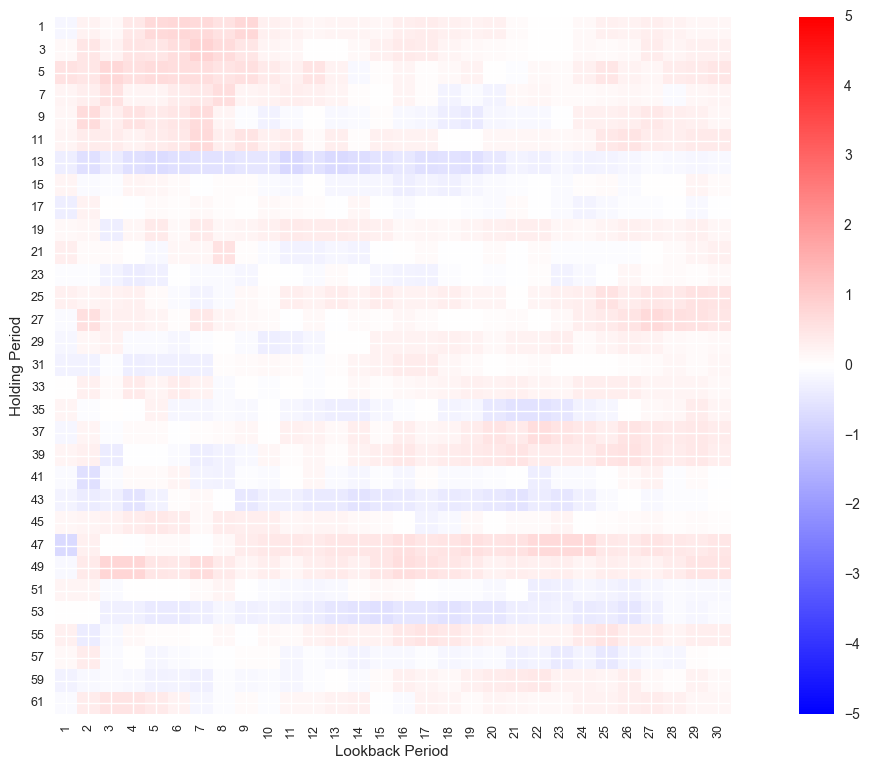

In [11]:
normalize = mpl.colors.Normalize(vmin=-5, vmax=5)
heatmap(short, normalize)

### 4) Intermediate Term Momentum Analysis

Intermediate term momentum is calculated for returns over a lookback period of 6 to 12 months and a heatmap is produced using *matplotlib* to visualize these results in the same manner as short term (Step 3). The momentum strategy Sharpe Ratio heatmap again shows positive values in red and negative values in blue. As expected, we find intermediate term periods to exhibit a continued trend over future periods of similar length since our cumulative plots indicated a negative trend in price most recently. It is important to note that we see a strong negative momentum at a lookback period of 3.75 months and holding period of almost 2 years. While we see a strong positive momentum with lookback at 4.5-6.5 months and holding at 0-3 months, we observe far more negative Sharpe Ratios for our intermediate term momentum compared to short term momentum, supporting research's claim that trends may continue in the intermediate term.

In [12]:
%time intermediate = sr_combos(1, 365, 14, 1, 730, 30)

Wall time: 1min 31s


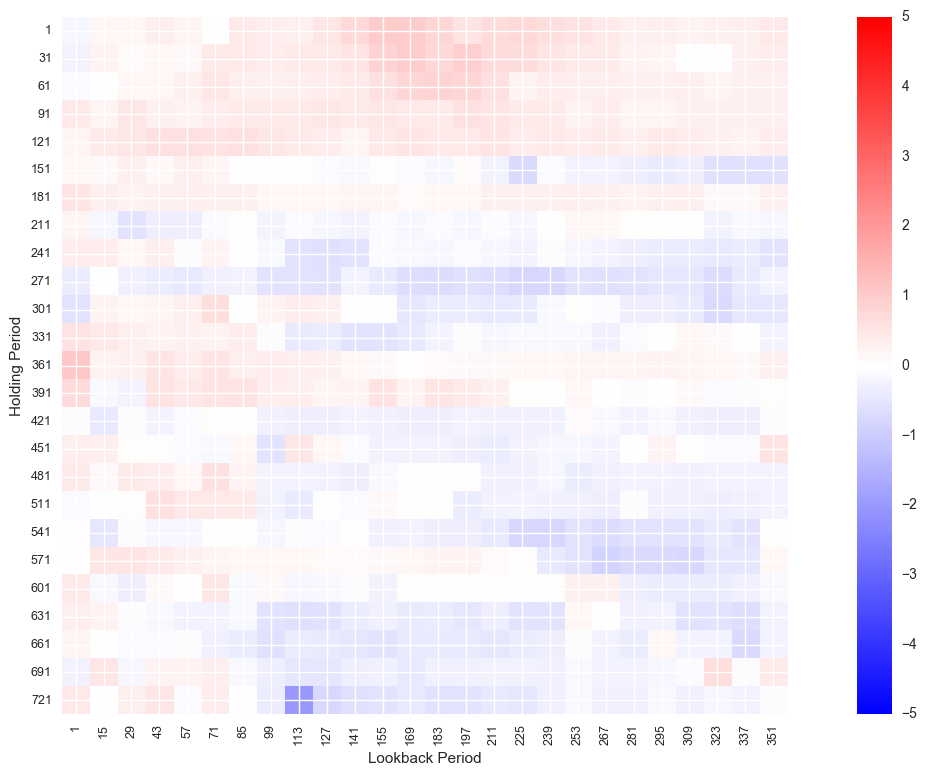

In [13]:
normalize = mpl.colors.Normalize(vmin=-5, vmax=5)
heatmap(intermediate, normalize)

### 5) Long Term Momentum Analysis

In this section we will evaluate our portfolio using the long term momentum type. To accomplish this, we must calculate all possible combinations of lookback windows and holding periods. The lookback window values will consist of 3 years of data (1095 days), grouped by 60 day intervals. The holding periods will consist of 6 years of data (2190 days), grouped by 120 day intervals. The momentum will be based on the Sharpe Ratio, which is calculated using the backtesting function and output for each combination.

In [14]:
%time long = sr_combos(1, 1095, 60, 1, 2190, 120)

Wall time: 57.9 s


In [15]:
print("Max SR: ", max(long.max(axis=1)))
print("Min SR: ", min(long.min(axis=1)))
axmean_long = long.mean(axis=1)
print("SR Mean: ", axmean_long.mean())

Max SR:  4.75524163122
Min SR:  -38.1229534206
SR Mean:  -0.41546335536


The highest Sharpe Ratio value was 4.7552 with lookback equal to 1 and hold period equal to 1561. The lowest Sharpe Ratio value was -38.1230, displaying a significantly higher variance than the other momentum types.

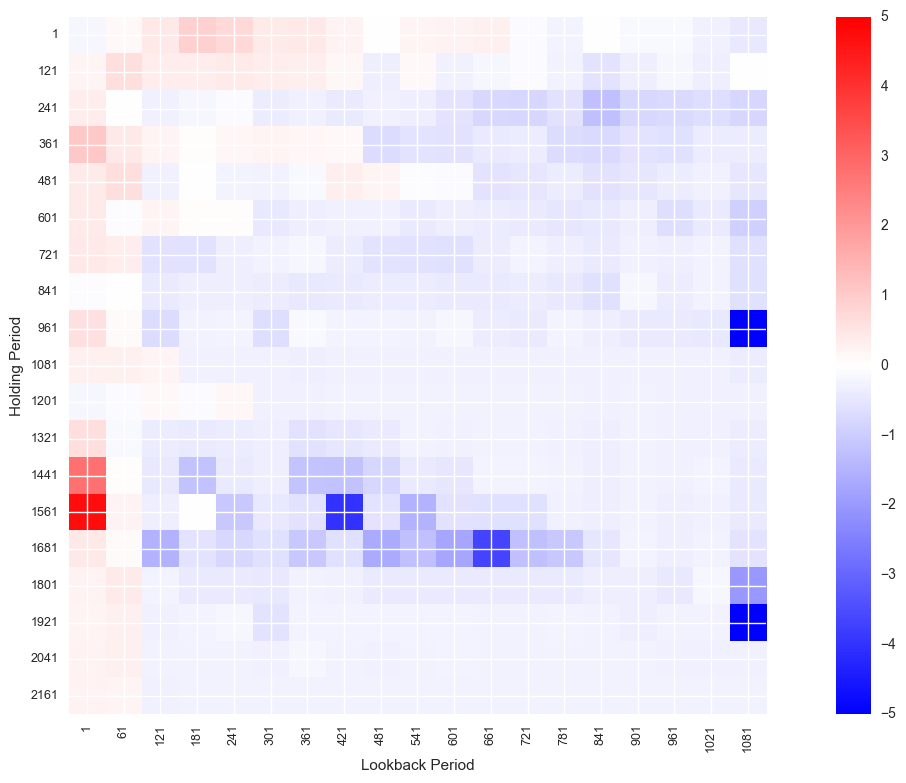

In [16]:
normalize = mpl.colors.Normalize(vmin=-5, vmax=5)
heatmap(long, normalize)

The graphic above shows a heatmap of the Sharpe Ratio calculations based on the lookback windows and holding period combinations. The momentum strategy Sharpe Ratio heatmap again shows positive values in red and negative values in blue. It is interesting that the first couple lookback periods show a high Sharpe Ratio, even across longer holding periods. However, the Sharpe Ratio begins to decrease, only showing high values in the lookback period through 10 months and only for holding periods through 4 months. Following this, there appears to only be  0 or negative Sharpe Ratios for combinations of lookback and holding periods. This analysis confirms the belief that long term momentum results are similar to those of short term momentum results, in the fact that there will be a return reversal. This portfolio analysis confirms existing research - long term momentum is not the optimal momentum type.

### 6) Portfolio Research Based on Best Strategy

According to current research, the best strategy theory is to use the intermediate momentum combination of a 12 month lookback window with a 3 month holding period [7]. Again, this is a theory and may not be the best strategy for every portfolio. The contents of a portfolio will influence the parameters of lookback and holding combination resulting in the best strategy and, as always, anomalies will occur. Evaluation of this portfolio may not result in the best strategy theory holding true as the dataset is based on influencing factors. The portfolio used in this case study lacks diversity; all stocks are semiconductor related corporations. A portfolio built on one sector, especially one specialty, increases the likelihood of a stock's performance directly impacting another. 

Let's start by showing the best strategy theory calcuation on this dataset. The cell below shows a Sharpe Ratio of 0.1596 using the 12 month lookback and 3 month holding combination. This strategy actually shows a positive return, without needing to dig deep into the dataset. To start, the best strategy theory seems sound in the fact that it has a positive return on this unseen dataset, while the majority of the combinations return negative values. 

In [17]:
#Sharpe value calculation for best strategy theory
strat_sr(px, 365, 90)

0.15960659841095653

The goal is to identify the best strategy for this portfolio and compare the results to the industry best strategy theory result (0.1596). To accomplish this we will use the backtesting function developed earlier and output multiple Sharpe Ratio metrics, providing the capability to derive high and low-level insights. Simply, we start with three momentum types, each assigned a large number of Sharpe Ratio metrics based on lookback and holding combination calculations, then analyze these metrics to identify the best strategy. The first metric we will discuss is the highest-level metric derived from each momentum type, the overall Sharpe Ratio mean. While this metric does not help us identify the existence or frequency of return reversals and/or the severity of a reversal, it can be useful in the evaluation of the entire momentum type performance.

In [18]:
axmean_short = short.mean(axis=1)
print("Short term SR Mean:         ", axmean_short.mean())
axmean_intermediate = intermediate.mean(axis=1)
print("Intermeidate term SR Mean: ", axmean_intermediate.mean())
axmean_long = long.mean(axis=1)
print("Long term SR Mean SR Mean: ", axmean_long.mean())

Short term SR Mean:          0.095403545989
Intermeidate term SR Mean:  -0.000606678356147
Long term SR Mean SR Mean:  -0.41546335536


The momentum type mean metric should not carry much weight in the best strategy selection, though it does allow us to view the momentum type as a whole and decide if returns are likely to be positive or negative. Clearly, the long term momentum does not perform well overall and is unlikely to have a "sweetspot" capable of positive returns. Long term momentum will be ruled out based on this overall performance metric coupled with the analysis from Section 5 showing no positive returns beyond the initial combination periods.

Next we will look at the highest Sharpe Ratio for both the short and intermediate momentum types.

In [19]:
print("Short term max SR:        ", max(short.max(axis=1)))
print("Intermediate term max SR: ", max(intermediate.max(axis=1)))

Short term max SR:         0.846540059235
Intermediate term max SR:  1.0646819374


The short term max Sharpe Ratio value is 0.8465 with parameters of lookback window equal to 14 days and holding period equal to 3 days. The intermediate term max Sharpe Ratio value is 1.0647 with parameters of lookback equal to 14 days and holding period equal to 361 days.

In [20]:
short_std = short.std(axis=1)
print(short_std)
print("Short std dev mean: ", short_std.mean())
inter_std = intermediate.std(axis=1)
print(inter_std)
print("Intermediate std dev mean: ", inter_std.mean())

Holding Period
1     0.222454
3     0.214099
5     0.238689
7     0.192380
9     0.300672
11    0.156930
13    0.197182
15    0.146178
17    0.115820
19    0.140359
21    0.175120
23    0.132531
25    0.187910
27    0.221788
29    0.189010
31    0.188588
33    0.132356
35    0.237512
37    0.201655
39    0.259684
41    0.165477
43    0.193745
45    0.145618
47    0.296482
49    0.190712
51    0.147858
53    0.161199
55    0.189523
57    0.156334
59    0.218000
61    0.176049
dtype: float64
Short std dev mean:  0.190061726624
Holding Period
1      0.281214
31     0.302002
61     0.224526
91     0.103415
121    0.111612
151    0.291768
181    0.090949
211    0.168315
241    0.288776
271    0.185259
301    0.356984
331    0.304323
361    0.198319
391    0.259548
421    0.138729
451    0.268472
481    0.281745
511    0.286163
541    0.259393
571    0.428021
601    0.241902
631    0.265748
661    0.228543
691    0.310127
721    0.480785
dtype: float64
Intermediate std dev mean:  0.254265509

By calculating the standard deviation of holding periods for the best selection as defined by max Sharpe value for this portfolio and the standard deviation of the best selection theory Sharpe value we can further understand the dataset. 

The intermediate momentum combination selected for this portfolio was lookback equal to 14 days and holding period equal to 361 days. This combination has standard deviation of 0.198319, while the best selection theory combination has a standard deviation of 0.103415. 

Stock and portfolio selection is not an absolute science. However, previous research guides us to a useful starting momentum type, lookback window, and hold period. Research in the field suggests using 12 months for the lookback window and 3 months for holding period and this research project seems to confirm this theory. While the best strategy scenario may not yield maximum Sharpe values for this dataset, it does provide a positive outcome and a lower standard deviation than the selected parameters.

## Discussion and Future Work
Proper stock market analysis and data mining require an adequate tool suite for effective insights. After performing portfolio analysis for five different stocks, which consisted of some basic exploratory analysis, a review of short, intermediate, and long term momentums, and a comparison against theory's best momentum strategy, we agree that Python, with *pandas*, meets such needs. We were able to confirm momentum performance exhibits the same characteristics of continuum and reversal as existing research suggests. Our assessment using Python also revealed that our portfolio's best momentum strategy closely matches that theorized to be optimum (one year lookback, three month holding period), particularly when reviewing Sharpe Ratio standard deviations. To summarize, our analysis and existing research were both in alignment with one another, supporting the argument that Python provides the tools necessary to analyze stock market data.

As extension of this effort, future works include three items of interest. The first is to analyze a more diversified stock portfolio consisting of stocks from more than just a single industry such as was performed herein. With such diversification, we would plan to include at least twenty stocks in contrast to the mere five included in this case study. The second item of interest for future work would be to also extend our application into other areas such as future contract rolling. Doing so would extend demonstration of Python's financial data efficiencies. Finally, the third item of interest would be to replicate all these efforts using the R programming language. This would enable us to review R's financial data capabilities and allow us to compare both Python and R in terms of financial and time-series data efficiencies.

## References
[1] B. Lehmann, “Fads, Martingales, and Market Efficiency,” The Quarterly Journal of Economics, vol. 105, no. 1, pp. 1–28, Feb. 1990.<br>
[2] Investopedia "Cumulative Return",  31-Jul-2017. [Online]. Available: http://www.investopedia.com/terms/c/cumulativereturn.asp. [Accessed: 25-Sep-2017].<br>
[3] I. Staff, “Momentum,” Investopedia, 29-Jul-2015. [Online]. Available: http://www.investopedia.com/terms/m/momentum.asp.<br>
[4] J. Hur, “History of The Stock Market,” BeBusinessEd, 05-Sep-2017. [Online]. Available: https://bebusinessed.com/history/history-of-the-stock-market/. [Accessed: 25-Sep-2017].<br>
[5] NASDAQ NXPI Historical Prices, 24-Sep-2017. [Online]. Available: http://www.nasdaq.com/symbol/nxpi/historical. [Accessed: 25-Sep-2017].<br>
[6] N. Jegadeesh, “Evidence of Predictable Behavior of Security Returns,” The Journal of Finance, vol. 45, no. 3, pp. 881–898, Jul. 1990.<br>
[7] N. Jegadeesh and S. Titman, “Returns to Buying Winners and Selling Losers: Implications for Stock Market Efficiency,” The Journal of Finance, vol. 48, no. 1, pp. 65–91, Mar. 1993.<br>
[8] W. F. Sharpe, “The Sharpe Ratio,” The Sharpe Ratio, 1994. [Online]. Available: https://web.stanford.edu/~wfsharpe/art/sr/sr.htm. [Accessed: 27-Sep-2017].<br>
[9] W. McKinney, Python for Data Analysis. Beijing: OReilly, 2014.<br>
 [Accessed: 23-Sep-2017].<br>
[10] YouTube, 11-Sep-2017. [Online]. Available: https://www.youtube.com/watch?v=KQJYb5YFIoE. [Accessed: 24-Sep-2017].<br>